In [1]:
# run `jupyter notebook` under project root dir
# calibration-framework
# https://github.com/fabiankueppers/calibration-framework.git
#!pip install --upgrade pip
!pip install netcal

In [2]:
import sys
#sys.path.insert(0, '/nfs/project/zhanghui/spk/voxceleb_trainer/tools/venv/bin/')
sys.executable

'/nfs/project/zhanghui/spk/voxceleb_trainer/tools/venv/bin/python'

In [3]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
!ls

calibration.ipynb  veri_test.txt
lr_decay.ipynb	   VoxCeleb1-O_aamsoftmax_eer1.7338.score


In [23]:
fname='VoxCeleb1-O_aamsoftmax_eer1.7338.score'
scores = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        scores[k1+' ' + k2] = float(s)
#print(scores)

In [24]:
#print(scores.keys())
print(scores['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])

0.5291130542755127


In [28]:
fname = 'veri_test.txt'
labels = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        labels[k1+' ' + k2] = int(s)
print(labels['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])

1


In [37]:
# scaling
#!pip list
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

print(sigmoid(0))
print(sigmoid(0.458))

0.5
0.6125396134409151


In [62]:
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from operator import itemgetter
def compute_eer(y_score, y, pos=1):
    # y denotes groundtruth scores,
    # y_score denotes the prediction scores.
    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=pos)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.) 
    thresh = interp1d(fpr, thresholds)(eer)
    print(f"EER : {eer*100:.4f} (threshold {thresh:.4f})")
    return eer, thresh, fpr, tpr 

def ComputeErrorRates(scores, labels):

    # Sort the scores from smallest to largest, and also get the corresponding
    # indexes of the sorted scores.  We will treat the sorted scores as the
    # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
        [(index, threshold) for index, threshold in enumerate(scores)],
        key=itemgetter(1)))
    sorted_labels = []
    labels = [labels[i] for i in sorted_indexes]
    fnrs = []
    fprs = []

    # At the end of this loop, fnrs[i] is the number of errors made by
    # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
    # is the total number of times that we have correctly accepted scores
    # greater than thresholds[i].
    for i in range(0, len(labels)):
        if i == 0:
            fnrs.append(labels[i])
            fprs.append(1 - labels[i])
        else:
            fnrs.append(fnrs[i-1] + labels[i])
            fprs.append(fprs[i-1] + 1 - labels[i])
    fnrs_norm = sum(labels)
    fprs_norm = len(labels) - fnrs_norm

    # Now divide by the total number of false negative errors to
    # obtain the false positive rates across all thresholds
    fnrs = [x / float(fnrs_norm) for x in fnrs]

    # Divide by the total number of corret positives to get the
    # true positive rate.  Subtract these quantities from 1 to
    # get the false positive rates.
    fprs = [1 - x / float(fprs_norm) for x in fprs]
    return fnrs, fprs, thresholds

# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target=0.05, c_miss=1, c_fa=1):
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

def compute_minDCF(scores, labels):
    fnrs, fprs, thresholds = ComputeErrorRates(scores, labels)
    c_miss=1
    c_fa = 1
    p_target = 0.05
    mindcf, threshold_default = ComputeMinDcf(fnrs, fprs, thresholds, 
        p_target=p_target, c_miss=c_miss, c_fa=c_fa)
    print(f"minDCF : {mindcf:.4f} (threshold {threshold_default:.4f} p-target={p_target}, c-miss={c_miss}, c-fa={c_fa})")                                                                                                                                       
    return mindcf, threshold_default

In [63]:
from netcal.scaling import TemperatureScaling

temperature = TemperatureScaling()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[0.94413144 0.71492776 0.96669036 0.48534587 0.9612912 ]


In [64]:
from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print(uncalibrated_score)
print(calibrated_score)

0.39419344243197585
0.2791039339559425


In [65]:
compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5642 (threshold 0.8234)
minDCF : 0.1043 (threshold 0.8897 p-target=0.05, c-miss=1, c-fa=1)


(0.10429480381760269, 0.8897064667825073)

In [66]:
from netcal.scaling import LogisticCalibration

temperature = LogisticCalibration()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[9.99247448e-01 3.38781438e-02 9.99962055e-01 1.57658711e-04
 9.99910245e-01]
0.39419344243197585
0.0017143520692864834
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5642 (threshold 0.5191)
minDCF : 0.1043 (threshold 0.9571 p-target=0.05, c-miss=1, c-fa=1)


(0.10429480381760269, 0.957100052740726)

In [67]:
from netcal.scaling import LogisticCalibrationDependent

temperature = LogisticCalibrationDependent()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[9.99656380e-01 3.41837632e-02 9.99992266e-01 3.73315954e-04
 9.99976300e-01]
0.39419344243197585
0.000810633288483189
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5642 (threshold 0.4960)
minDCF : 0.1043 (threshold 0.9611 p-target=0.05, c-miss=1, c-fa=1)


(0.10429480381760269, 0.9610692510711454)

In [69]:
from netcal.scaling import BetaCalibrationDependent

temperature = BetaCalibrationDependent()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[0.6652677  0.41297121 0.72655389 0.29120327 0.70966818]
0.39419344243197585
0.3015747651564614
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5642 (threshold 0.4970)
minDCF : 0.1043 (threshold 0.5712 p-target=0.05, c-miss=1, c-fa=1)


(0.10429480381760269, 0.5711511782412166)

In [71]:
from netcal.scaling import BetaCalibration

temperature = BetaCalibration()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[9.99245898e-01 3.36240887e-02 9.99961626e-01 1.52296572e-04
 9.99909512e-01]
ECE
0.39419344243197585
0.001676487051697433
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5642 (threshold 0.5193)
minDCF : 0.1043 (threshold 0.9572 p-target=0.05, c-miss=1, c-fa=1)


(0.10429480381760269, 0.9572189085467742)

In [72]:
from netcal.binning import NearIsotonicRegression

temperature = NearIsotonicRegression()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[1. 0. 1. 0. 1.]
ECE
0.39419344243197585
2.6511134676453126e-05
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 0.0053 (threshold 0.9999)
minDCF : 0.0001 (threshold 0.0000 p-target=0.05, c-miss=1, c-fa=1)


(5.302226935312831e-05, 0.0)

In [80]:
from netcal.binning import NearIsotonicRegression

temperature = NearIsotonicRegression(quick_init=False)

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[1. 0. 1. 0. 1.]
ECE
0.39419344243197585
2.6511134676453126e-05
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 0.0053 (threshold 0.9999)
minDCF : 0.0001 (threshold 0.0000 p-target=0.05, c-miss=1, c-fa=1)


(5.302226935312831e-05, 0.0)

In [73]:
from netcal.binning import IsotonicRegression

temperature = IsotonicRegression()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[9.99655172e-01 3.86473430e-02 1.00000000e+00 8.33472245e-04
 1.00000000e+00]
ECE
0.39419344243197585
2.2139293020518855e-14
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5476 (threshold 0.5612)
minDCF : 0.1024 (threshold 0.9447 p-target=0.05, c-miss=1, c-fa=1)


(0.10243902439024383, 0.9447236180904522)

In [78]:
from netcal.binning import HistogramBinning

temperature = HistogramBinning(bins=10)

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[0.99900182 0.14152772 0.99900182 0.00115652 0.99900182]
ECE
0.39419344243197585
4.3554405962008853e-14
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 8.3608 (threshold 0.8782)
minDCF : 0.1144 (threshold 0.1415 p-target=0.05, c-miss=1, c-fa=1)


(0.11436903499469787, 0.14152772392400156)

In [79]:
from netcal.binning import HistogramBinning

temperature = HistogramBinning(bins=10000, equal_intervals=False)

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

ValueError: Parameter 'equal_intervals=False' is currently not implemented.

In [77]:
from netcal.binning import HistogramBinning

temperature = HistogramBinning(bins=10000)

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[1.         0.05882353 1.         0.         1.        ]
ECE
0.39419344243197585
2.0996086703232436e-16
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.3494 (threshold 0.5412)
minDCF : 0.0627 (threshold 0.9333 p-target=0.05, c-miss=1, c-fa=1)


(0.06272534464475145, 0.9333333333333333)

In [81]:
from netcal.binning import ENIR

temperature = ENIR()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[9.99655172e-01 3.68563686e-02 1.00000000e+00 8.11339547e-04
 1.00000000e+00]
ECE
0.39419344243197585
0.0008472998093048646
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5023 (threshold 0.5619)
minDCF : 0.0984 (threshold 0.9463 p-target=0.05, c-miss=1, c-fa=1)


(0.09840933191940544, 0.9463483146067425)

In [83]:
from netcal.binning import BBQ

temperature = BBQ(score_function='AIC')

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)


 12%|█▏        | 41/334 [00:00<00:00, 401.54it/s]

minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]


100%|██████████| 334/334 [00:01<00:00, 294.95it/s]


[9.99637414e-01 4.28904102e-02 1.00000000e+00 2.85715643e-06
 1.00000000e+00]
ECE
0.39419344243197585
0.0005970402972306234
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5585 (threshold 0.4776)
minDCF : 0.1026 (threshold 0.9666 p-target=0.05, c-miss=1, c-fa=1)


(0.1025980911983035, 0.9665664423173169)

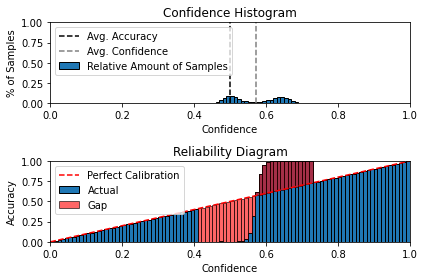

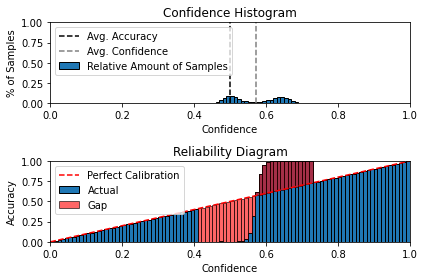

In [93]:
from netcal.presentation import ReliabilityDiagram

#n_bins = [10, 10]
n_bins= [100]

diagram = ReliabilityDiagram(n_bins, detection=False)    # flag 'detection=True' is mandatory for this method
diagram.plot(confidences, ground_truth)                # visualize miscalibration of uncalibrated

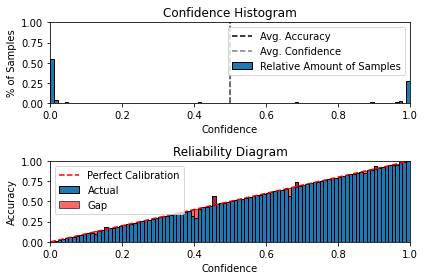

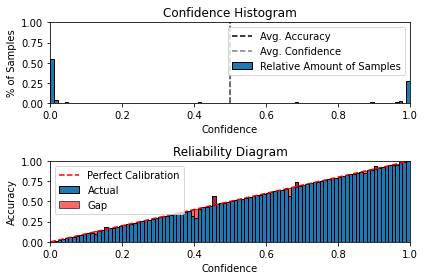

In [94]:
diagram.plot(calibrated, ground_truth)     # visualize miscalibration of calibrated

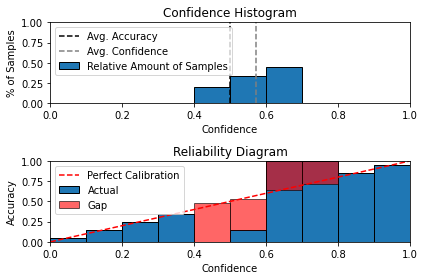

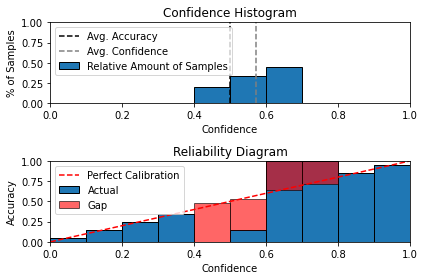

In [97]:
from netcal.presentation import ReliabilityDiagram

#n_bins = [10, 10]
n_bins= [10]

diagram = ReliabilityDiagram(n_bins, detection=False)    # flag 'detection=True' is mandatory for this method
diagram.plot(confidences, ground_truth)                # visualize miscalibration of uncalibrated

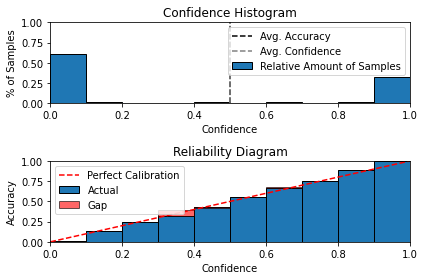

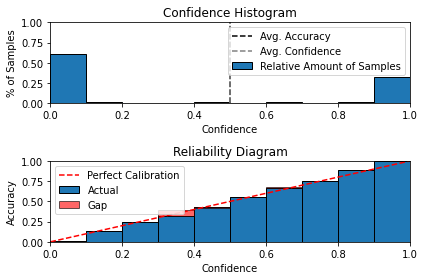

In [98]:
diagram.plot(calibrated, ground_truth)     # visualize miscalibration of calibrated